Main objectives of this notebook:
* investigate form of matrix $A$ after shift intervention
* simulation study for the rank of $A$ on graphs with $p\in\{2,3,4,5,6,7,8,9,10,50\}$.

### Preparation

In [1]:
import numpy as np
from sympy import *
import warnings
from scipy.linalg import solve_continuous_lyapunov
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
init_printing(use_unicode=True)

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def create_A_Sigma_sympy(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A_sympy(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

def simulate_M(seed: int, p: int) -> Array:
    np.random.seed(seed=seed)
    normal_matrix = np.random.normal(0, 1, (p, p))
    for i in range(p): # adjust diagonal entries s.t. M stable
        normal_matrix[i, i] = - np.sum(np.abs(normal_matrix[i, :]))
    return normal_matrix

def create_A_Sigma(cov: Array, p: int) -> Array:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = np.empty(shape=(row_num, col_num), dtype=float)
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A(A_Sigma: Array, mean: Array, p: int) -> Array:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = np.hstack((identity, mean[i] * eye(p)))
    return np.vstack((A_Sigma, identity))

num_exp = 1000 # number of true matrices per case
num_sim = 1000 # number of simulations per true matrix

index_intervention = 1
b = 10

### 2 nodes
$\text{rank}(A) = 4 = p^2$

$\frac{p(p+3)}{2} = 5$

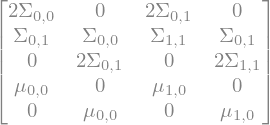

In [2]:
p = 2
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [3]:
A.rank()

In [4]:
A_Sigma.rank()

### 3 nodes
$\text{rank}(A) = 8 = p^2 - 1$

$\frac{p(p+3)}{2} = 9$

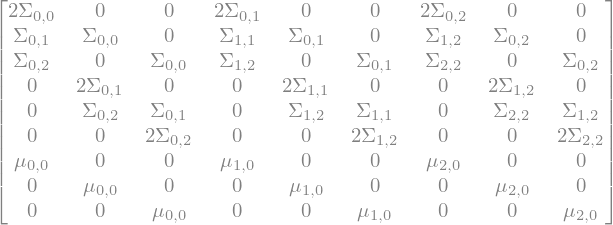

In [5]:
p = 3
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [6]:
A.rank()

In [7]:
A_Sigma.rank()

### 4 nodes
$\text{rank}(A) = 13 = p^2 - 3$

$\frac{p(p+3)}{2} = 14$

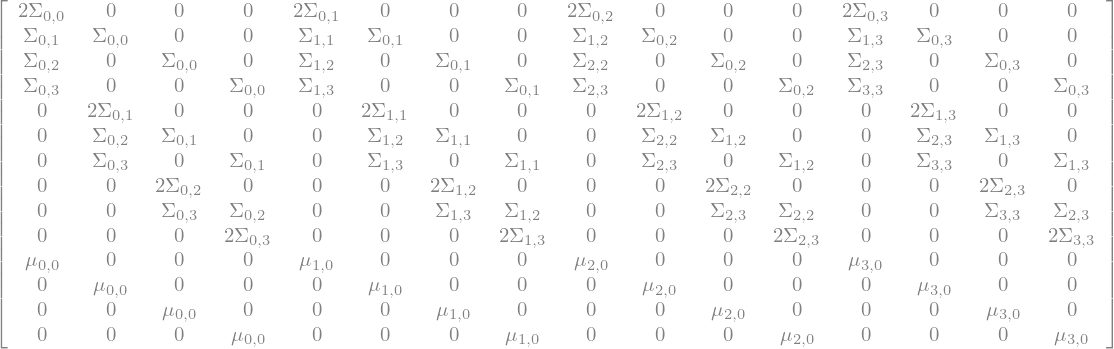

In [10]:
p = 4
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

In [11]:
p = 4
offset = 240

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_4 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_4[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_4)))
print(int(np.max(rank_4)))
print(num_sym(p) + p)

13
13
14


### 5 nodes
$\text{rank}(A) = 19 = p^2 - 6$

$\frac{p(p+3)}{2} = 20$

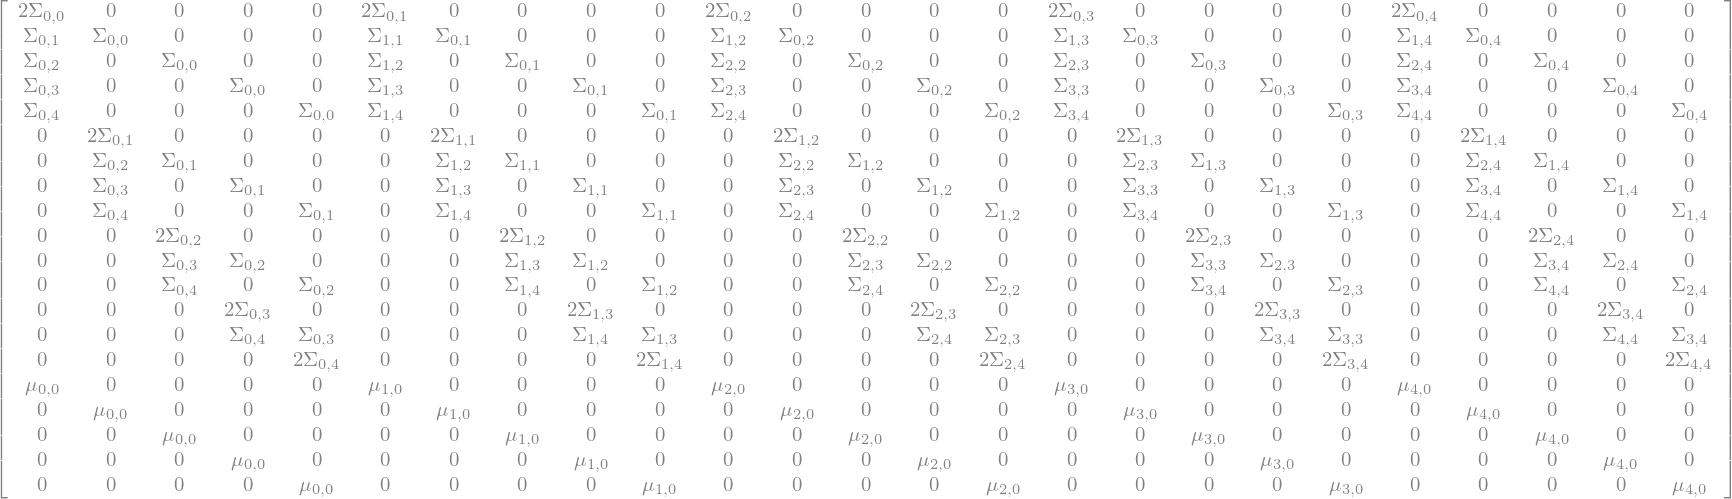

In [17]:
p = 5
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
A

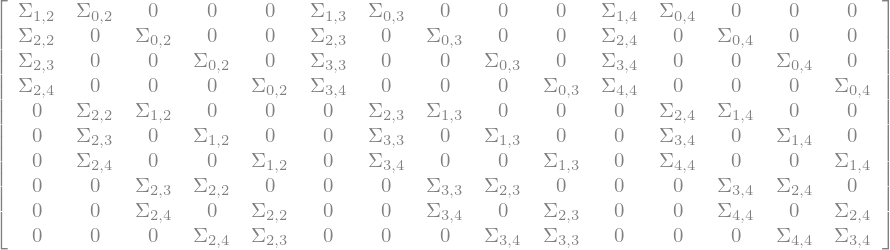

In [18]:
new_A_5 = A[[1, 2, 3, 4, 6, 7, 8, 10, 11, 13], 10:]
new_A_5

In [19]:
p = 5
offset = 2409

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_5 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_5[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_5)))
print(int(np.max(rank_5)))
print(num_sym(p) + p)

19
19
20


### 6 nodes
$\text{rank}(A) = 26 = p^2 - 10$

$\frac{p(p+3)}{2} = 27$

In [20]:
p = 6
Sigma = MatrixSymbol("Sigma", p, p).as_mutable()
cov = Matrix(p, p, lambda i, j: Sigma[min(i,j),max(i,j)])
mean = MatrixSymbol("mu", p, 1).as_mutable()
A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)
# A

In [21]:
p = 6
offset = 24090

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_6 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_6[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_6)))
print(int(np.max(rank_6)))
print(num_sym(p) + p)

26
26
27


### 7 nodes

In [22]:
p = 7
offset = 240901

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_7 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_7[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_7)))
print(int(np.max(rank_7)))
print(num_sym(p) + p)

34
34
35


### 8 nodes

In [23]:
p = 8
offset = 240901

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_8 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_8[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_8)))
print(int(np.max(rank_8)))
print(num_sym(p) + p)

43
43
44


### 9 nodes

In [24]:
p = 9
offset = 2409012

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_9 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_9[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_9)))
print(int(np.max(rank_9)))
print(num_sym(p) + p)

53
53
54


### 10 nodes

In [25]:
p = 10
offset = 24090123

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_10 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_10[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_10)))
print(int(np.max(rank_10)))
print(num_sym(p) + p)

64
64
65


### 50 nodes

In [26]:
p = 50
offset = 240901456

C = 2 * np.eye(p)
unit_v = np.eye(p)[:, index_intervention]

rank_50 = np.empty(shape=(num_exp), dtype=object)

for seed in range(offset, num_exp + offset):
    true_M = simulate_M(seed=seed, p=p)

    true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
    true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

    obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
    emp_cov = np.cov(obs, rowvar=False)
    emp_mean = np.mean(obs, axis=0)

    emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
    emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)
    emp_A = np.float64(emp_A)

    rank_50[seed - offset] = np.linalg.matrix_rank(emp_A)

print(int(np.min(rank_50)))
print(int(np.max(rank_50)))
print(num_sym(p) + p)

1324
1324
1325
